## Load necessary python libraries

In [1]:
import os
import napari
import tifffile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

import bigfish.plot as plot

from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import saveSpotsNPZ
from bigfish.detection.utils import get_object_radius_pixel
from bigfish.detection.utils import get_breaking_point
from matplotlib.backends.backend_qt5agg import FigureCanvas
from dask.array.image import imread as imr
from imaris_ims_file_reader.ims import ims
from kneed import KneeLocator

from pathlib import Path
from napari.layers import Image
from magicgui import magicgui, magic_factory, widgets
from magicgui.widgets import Table

print("Big-FISH version: {0}".format(bigfish.__version__))
print("numpy version: {0}".format(np.__version__))

print('Average measured size from image :',(123.4/1024)*20) #objectRad in nm

Big-FISH version: 0.6.2
numpy version: 1.23.0
Average measured size from image : 2.41015625


In [6]:
mIdentifier = 'cell_'
MaxTimePoint = 899

# Run GUI

In [7]:
VOXEL_RADIUS = (0,0,0)
OBJECT_RADIUS = (0,0,0)

DEFAULT_CHOICES=['None']
SET_TABLE = 0
CELL_CHOICE = 0
DEBUG = False
@magicgui(auto_call=True,    
    main_window=False,
          persist=False,
    base_folder={"label": "Choose home folder:",
                 'mode': 'd'},
    dropdown=dict(
            widget_type="Select", choices=DEFAULT_CHOICES, label="Choose cell to analyse"
        ),
    layout="vertical",
         )
def choose_home_folder(dropdown, base_folder = Path.home()):
    if DEBUG==True:    
        print("calling choose home folder")
        print('dropdown :', dropdown)
        print('bf: ', base_folder)

    return base_folder, dropdown

@choose_home_folder.changed.connect
def choose_cell_on_file_change(event=None):
    global SET_TABLE, CELL_CHOICE
    if DEBUG==True: 
        print('calling populate cell choices')
        print('choose home folder count :', choose_home_folder.call_count)
    if choose_home_folder.call_count == 1 and SET_TABLE==0:
        SET_TABLE = 1
        if DEBUG==True: print('value of set table set to : ', SET_TABLE)
    hm = choose_home_folder.base_folder.value
    cellChoices = [i for i in os.listdir(hm) if mIdentifier in i and len(os.listdir(os.path.join(hm,i)))>=MaxTimePoint]
    cellChoices.sort()
    if cellChoices is not None:
        choose_home_folder.dropdown.choices = cellChoices
        global DEFAULT_CHOICES
        DEFAULT_CHOICES = deepcopy(cellChoices)
        choose_home_folder.dropdown.value = cellChoices[CELL_CHOICE]
        


@choose_home_folder.called.connect
def on_dropdown_changed(value: str):
    def catchval(new_value):
        thresholdTable[new_value['column_header']][new_value['row_header']] = new_value['data']
        table.to_dataframe().to_csv(str(value[0])+'/'+'thresholds.csv')
    
    if DEBUG==True: 
        print('calling on drowpdown changed')
        print(value)
    global SET_TABLE, CELL_CHOICE, DEFAULT_CHOICES
    if np.size(value[1])!=0:
        if DEBUG==True: print('chosen cell', str(value[1][0]))
        CELL_CHOICE = DEFAULT_CHOICES.index(value[1][0])
        getFolderName.folder_name.value = os.path.join(str(value[0]), str(value[1][0]))
        if SET_TABLE==1:
            
            hm = str(choose_home_folder.base_folder.value)
            if os.path.exists(hm+'/'+'thresholds.csv'):
                df = pd.read_csv(hm+'/'+'thresholds.csv', index_col=0)
                thresholdTable = df.to_dict()
            else:
                if DEBUG==True: print('calling set table', hm)
                cellChoices =  [i for i in os.listdir(hm) if mIdentifier in i and len(os.listdir(os.path.join(hm,i)))>=MaxTimePoint]
                cellChoices.sort()
                rows = np.arange(len(cellChoices))

                rownames = ['r'+str(element) for element in rows]
                column1 = {rownames[i]: cellChoices[i] for i in range(len(cellChoices))}
                column2 = {rownames[i]: 0 for i in range(len(cellChoices))}
                column3 = {rownames[i]: 0 for i in range(len(cellChoices))}
                thresholdTable = {
                    "cell": column1,
                    "threshold": column2,
                    "Tx_Sites":column3

                }         
            table = Table(value=thresholdTable)
            table.changed.connect(catchval)
            tablewidget = viewer.window.add_dock_widget(table, tabify=False, name = 'threshold table')
            SET_TABLE = 0

    else:
        print('no cells found')
        getFolderName.folder_name.value = str(value[0])   
        
        
@magicgui(
    auto_call=False,
    layout="vertical",
    show_MIP={
        "widget_type": "RadioButtons",
        "orientation": "horizontal",
        "choices": [("yes", True), ("no", False)],
    },
)
def getFolderName(
    folder_name="cell folder",
    show_MIP=False,
    
    ):
    """Callable function A."""
    print("calling getFolderName")
    if not os.path.exists(folder_name):
        folder_name = Path.home()
    return folder_name, show_MIP

@getFolderName.called.connect
def _on_func_getFolderName(value: str):
    showMovie.input.value = value[0]
    showMovie.showMip.value = value[1]
    

@magicgui(auto_call=True, input={"visible": False, "label": " "}, showMip={"visible": False}, persist=True)
def showMovie(input: str, showMip :bool)-> "napari.types.LayerDataTuple":
    """Callable function B."""
    print("calling showMovie")
    homefolder = input
    if any(fname.endswith(r".tif") for fname in os.listdir(homefolder)):
        print('Stackcell found')
        stackCell = imr(homefolder+'/*t*.tif')
        metadata = {'name': 'stackCell', 'colormap': 'green', 'cellFolderName': homefolder}
        layer_type = 'image'
        viewer = napari.current_viewer()

        if showMip == True:
            print("getting mip")
            maxImageCell = np.max(stackCell, axis=1)
            image_layer = viewer.add_image(maxImageCell,
                         colormap='green')
        else:
            image_layer = viewer.add_image(stackCell,
                         colormap='green')

        return (stackCell, metadata, layer_type)

@magicgui(main_window=False,
          call_button='Set voxel parameters',
          voxel_radius_z = {"widget_type": "IntSlider", 'max': 1000},
          voxel_radius_xy = {"widget_type": "IntSlider", 'max': 1000},
          object_radius_z = {"widget_type": "IntSlider", 'max': 1000},
          object_radius_xy = {"widget_type": "IntSlider", 'max': 1000})

def setVoxelandObjectParameters(voxel_radius_z=600,
                                voxel_radius_xy = 121,
                                object_radius_z=600,
                                object_radius_xy=150,
    ):

    voxelRadius = (voxel_radius_z, voxel_radius_xy, voxel_radius_xy)
    objectRadius = (object_radius_z, object_radius_xy, object_radius_xy)
    return voxelRadius, objectRadius
@setVoxelandObjectParameters.called.connect
def on_set_vb_parameters(value: list):
    global VOXEL_RADIUS
    global OBJECT_RADIUS
    VOXEL_RADIUS = value[0]
    OBJECT_RADIUS = value[1]
    if DEBUG==True: 
        print('voxel ', VOXEL_RADIUS)
        print('object', OBJECT_RADIUS)



@magicgui(main_window=False,
             sampling_rate={'min': 5, 'max':50},)
def getThreshold(img_layer: "napari.layers.Image", sampling_rate: int) -> "napari.types.LayerDataTuple":
    print('calling getThreshold')
    image_data = img_layer.data #
    layer_type = 'image'
    metadata = {'colormap': 'green','name': 'stackCell', 'samplingRate': sampling_rate} 
    return image_data, metadata, layer_type

@getThreshold.called.connect
def runThresholdEstimator(value: int):
    global VOXEL_RADIUS
    global OBJECT_RADIUS
    print('calling runThresholEstimator')
    print('fol nam',getFolderName.folder_name.value)
    mpl_widget = FigureCanvas(plt.figure(figsize=(5,10)))
    images = []
    spots_list=[]
    stackCell = value[0]
    MaxTimePoint = len(value[0])
    samplingRate = value[1]['samplingRate']
    for t in range(0,MaxTimePoint,samplingRate):
        rna = np.array(stackCell[t])
        images.append(rna)
    print("Total number of images : "+str(len(images)))
    viewer = napari.current_viewer()
    viewer.window.add_dock_widget(mpl_widget,tabify=True, name = 'elbow plot')
    spots_image_list, threshold_image_list = detection.detect_spots(
    images=images, 
    return_threshold=True, 
    voxel_size=VOXEL_RADIUS,  # in nanometer (one value per dimension zyx)
    spot_radius=OBJECT_RADIUS)  # in nanometer (one value per dimension zyx)

    thresholds, count_spots, threshold = detection.get_elbow_values(
            images,
            voxel_size=VOXEL_RADIUS,
            spot_radius=OBJECT_RADIUS
    )
    print('Automatic threshold found!')
    knees = []
    norm_knees = []

    kneedle = KneeLocator(
        thresholds, count_spots, S=1, curve="convex", direction="decreasing", online=False)

    xx = np.argmax(kneedle.y_difference)
    plt.subplot(2, 1, 2)
    plt.plot(kneedle.x_normalized, kneedle.y_normalized, label = 'normalized curve', color='blue')
    plt.plot(kneedle.x_difference, kneedle.y_difference, label = 'difference curve', color='red')
    plt.scatter(kneedle.x_difference[xx], kneedle.y_difference[xx])
    plt.text(kneedle.x_difference[xx], kneedle.y_difference[xx]*0.7, 'threshold = '+str(kneedle.x[xx]))
    plt.text(np.max(kneedle.x_difference)*0.85/2, 0.70, 'no. of images = '+str(len(images)))
    plt.text(np.max(kneedle.x_difference)*0.85/2, 0.65, 'cell number = ') #+str(cellNumber))
    plt.text(np.max(kneedle.x_difference)*0.85/2, 0.60, 'imsQ = F') #+str(imsQ))
    plt.legend()

    plt.subplot(2, 1, 1)
    sctx = get_breaking_point(thresholds, count_spots)
    plt.plot(thresholds, count_spots)
    plt.scatter(sctx[0],count_spots[thresholds==sctx[0]], color='red')
    plt.text(sctx[0], count_spots[thresholds==sctx[0]]*1.2, 'threshold = '+str(sctx[0]))
    plt.xlabel('Thresholds')
    plt.ylabel('mrna detected (log scale)') 
    return threshold


@magicgui(main_window=False,
         call_button="Verify threshold",
        threshold = {"widget_type": "IntSlider", 'max': 6000},
         )

def recordThreshold(img_layer: "napari.layers.Image", threshold: int):
    image_data = img_layer.data
    samples = len(image_data)//10

    stackCellSample = image_data[::samples,:,:,:]
    if 'stack Cell Sample' not in viewer.layers:
        image_layer = viewer.add_image(stackCellSample,
                             colormap='green',
                                name='stack Cell Sample')

    return stackCellSample, threshold


    
def formatSpotsShape(spotList):
    spotArray = np.hstack([np.ones((len(spotList[0]),1))*0, spotList[0]])
    for i in range(1,len(spotList)):
        spotArray = np.vstack([spotArray,np.hstack([np.ones((len(spotList[i]),1))*i, spotList[i]])])
    return spotArray    
   

@recordThreshold.called.connect
def on_verify_threshold(value: str):
    print('calling verify threshold')
    stackCellSample = value[0]
    threshold = value[1]
    spots_current_list = []
    for t in range(len(stackCellSample)):
        rna = np.array(stackCellSample[t])

        # spot radiuspathToTimeFrames
        spot_radius_px = detection.get_object_radius_pixel(
            voxel_size_nm=VOXEL_RADIUS,
            object_radius_nm=OBJECT_RADIUS, 
            ndim=3)

        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)

        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

        # thresholding

        spots_current, _ = detection.spots_thresholding(rna_log, mask, threshold)
        spots_current_list.append(spots_current)
    spotList = formatSpotsShape(spots_current_list)

    bigfish_Spots = viewer.add_points(
        spotList,
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots'+str(threshold)
        )
    if 'stackCell' in viewer.layers:
        viewer.layers.remove('stackCell')

    if 'stackCell Corrected (Exponential Curve Method)' in viewer.layers:
        viewer.layers.remove('stackCell Corrected (Exponential Curve Method)')

        
@magicgui(main_window=False,
         call_button="Analyse new cell",
         )
def loadNewCell():
    viewer.layers.select_all()
    viewer.layers.remove_selected()

@magicgui(main_window=False,
         call_button="Analyse new movie",)
def resetParametersForNewMovie():
    global CELL_CHOICE
    viewer.layers.select_all()
    viewer.layers.remove_selected()
    choose_home_folder.reset_call_count()
    CELL_CHOICE=0
    choose_home_folder.dropdown.value = DEFAULT_CHOICES[CELL_CHOICE]    
    

container = widgets.Container(
    widgets=[choose_home_folder, 
             getFolderName,
             showMovie, 
             setVoxelandObjectParameters, 
             getThreshold, 
             recordThreshold, 
             loadNewCell,resetParametersForNewMovie], layout="vertical", labels=False
)
container.native.setMinimumWidth(500)

viewer = napari.Viewer()
viewer.window.add_dock_widget(container, area="right", name = 'threshold estimation')

no cells found
calling getFolderName
calling showMovie
Stackcell found
no cells found
no cells found
calling verify threshold
no cells found
no cells found
calling verify threshold
no cells found
no cells found
calling verify threshold
no cells found
no cells found
calling verify threshold
no cells found
calling verify threshold
no cells found
calling verify threshold
no cells found
no cells found
no cells found
no cells found
no cells found
no cells found
no cells found
calling getFolderName
calling showMovie
Stackcell found
no cells found
no cells found
calling getFolderName
calling showMovie
Stackcell found
no cells found
calling getThreshold
calling runThresholEstimator
fol nam C:\Users\uid-1204\Desktop\test2_bigFISHLIVE\Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06\cell_14
Total number of images : 113
Automatic threshold found!
no cells found
calling verify threshold
no cells found
no cells found
calling verify threshold
no cells found
calling verify threshold
no cells fou

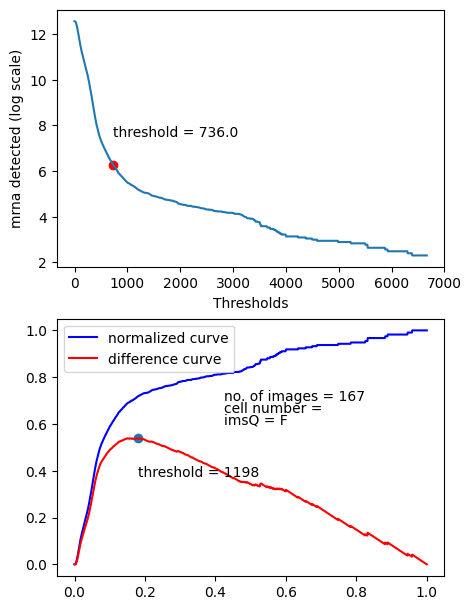

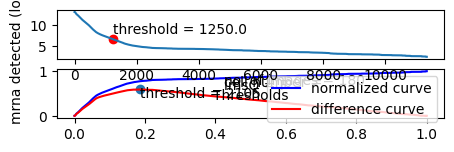

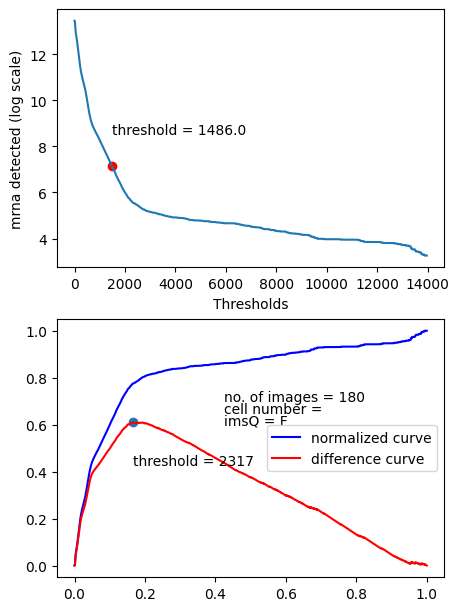

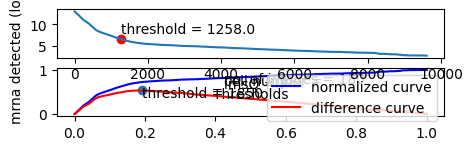

In [4]:
# import session_info


# session_info.show()